# Meta-Feature Engineering

In this notebook, meta-features are created from historical data of test users. These will be then used by classifier to identify optimal base-level algorithm for each user.

This notebook is structured as follows:

    1 Domain independent features
        1.1 Matrix based features
        1.2 Graph based features
        1.3 Timestamp based features
    2 Domain specific features
        2.1 Item attributes extraction from database and anonymization
        2.2 Feature creation
    3 Feature analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from ast import literal_eval
from multiprocessing import Pool
import time
from datetime import timedelta
import datetime
import psycopg2 as pg
import pandas.io.sql as psql
%matplotlib inline

In [2]:
# set default figsize
plt.rcParams['figure.figsize'] = [12, 4]

DATA_PATH = 'data/ustore/'
METRIC = 'NDCG@100'

In [5]:
rs_train = pd.read_csv(DATA_PATH+'raw/history.csv')

## 1 Domain independent features

### 1.1 Matrix based features

In [4]:
rs_perf = pd.read_csv(DATA_PATH+'rs_performance.csv')

In [5]:
rs_perf[METRIC] = rs_perf[METRIC].apply(lambda x: literal_eval(x))

In [6]:
data = rs_perf[rs_perf[METRIC].apply(lambda x: x[0][0] > 0)][['user_id', METRIC]]
data['class'] = data[METRIC].apply(lambda x: x[0][1])
data.head()

,user_id,NDCG@100,class
1,1,"[[0.11838279295536291, bpr], [0.05780921899607...",bpr
4,4,"[[0.5802792108518124, userknn], [0.37007816335...",userknn
5,5,"[[1.0, bpr], [1.0, als], [0.5, userknn], [0.18...",bpr
6,6,"[[0.071942683897578, popular], [0.0, userknn],...",popular
8,8,"[[0.09398963279503492, als], [0.0, userknn], [...",als


In [9]:
data.shape

(24002, 3)

In [8]:
rs_train_iids_per_uid = rs_train.groupby('user_id')['item_id'].apply(list).reset_index()

In [10]:
data = data.join(rs_train_iids_per_uid, how='inner', on='user_id', rsuffix='_')

In [11]:
data.head()

,user_id,NDCG@100,class,user_id_,item_id
1,1,"[[0.11838279295536291, bpr], [0.05780921899607...",bpr,1,"[10127, 45028, 50045, 53227, 53231, 53841, 586..."
4,4,"[[0.5802792108518124, userknn], [0.37007816335...",userknn,4,"[15519, 44289]"
5,5,"[[1.0, bpr], [1.0, als], [0.5, userknn], [0.18...",bpr,5,"[5132, 59072, 77534]"
6,6,"[[0.071942683897578, popular], [0.0, userknn],...",popular,6,"[39411, 50146, 50155, 50170, 69225, 70245, 703..."
8,8,"[[0.09398963279503492, als], [0.0, userknn], [...",als,8,"[21227, 62549, 62591]"


In [12]:
data['unique_items'] = data.item_id.apply(len)

In [16]:
%%time
num_cores = 8 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def compute_intersect_cardinality(df):
    df['itemsets_intersect_cardinality'] = df.apply(lambda x: list(filter((0).__ne__, 
        [len(set(x.item_id).intersection(set(ilist))) for u, ilist in enumerate(rs_train_iids_per_uid.item_id.values.tolist())
        if u != x.user_id])), axis=1)
    return df
    

data = parallelize_dataframe(data, compute_intersect_cardinality)

CPU times: user 1min 29s, sys: 35.3 s, total: 2min 5s
Wall time: 12h 50min 25s


Process ForkPoolWorker-8:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/

In [24]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

In [13]:
data = pd.read_csv(DATA_PATH+'meta/data.csv')
data['itemsets_intersect_cardinality'] = data['itemsets_intersect_cardinality'].apply(lambda x: literal_eval(x))
data[METRIC] = data[METRIC].apply(lambda x: literal_eval(x))
data['item_id'] = data['item_id'].apply(lambda x: literal_eval(x))

In [14]:
data.head()

,user_id,NDCG@100,class,user_id_,item_id,unique_items,itemsets_intersect_cardinality
0,1,"[[0.11838279295536291, bpr], [0.05780921899607...",bpr,1,"[10127, 45028, 50045, 53227, 53231, 53841, 586...",23,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ..."
1,4,"[[0.5802792108518124, userknn], [0.37007816335...",userknn,4,"[15519, 44289]",2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,5,"[[1.0, bpr], [1.0, als], [0.5, userknn], [0.18...",bpr,5,"[5132, 59072, 77534]",3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,6,"[[0.071942683897578, popular], [0.0, userknn],...",popular,6,"[39411, 50146, 50155, 50170, 69225, 70245, 703...",9,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,8,"[[0.09398963279503492, als], [0.0, userknn], [...",als,8,"[21227, 62549, 62591]",3,"[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [15]:
data.shape

(24002, 7)

Text(0.5,1,'Per user max cardinality of itemset itersection')

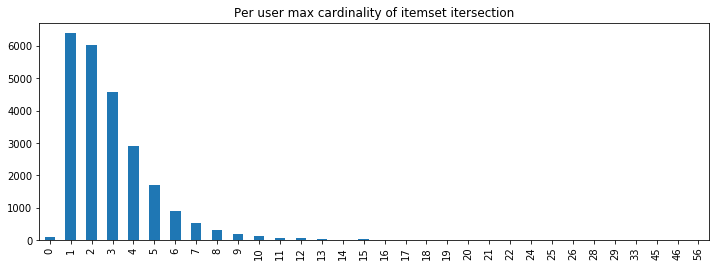

In [16]:
data.itemsets_intersect_cardinality.apply(lambda x: max(x) if len(x) > 0 else 0).value_counts().sort_index().plot(kind='bar')
plt.title('Per user max cardinality of itemset itersection')

In [17]:
%%time
num_cores = 8 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def create_meta_features(df):
    for i in range(1, 11):
        df['users_sharing_'+str(i)] = df.itemsets_intersect_cardinality.apply(lambda x: x.count(i))
        df['users_sharing_'+str(i)+'+'] = df.itemsets_intersect_cardinality.apply(lambda x: [c>=i for c in x].count(True))
        df['users_sharing_'+str(10*i)+'%+'] = df.apply(lambda x: 
                [c/x.unique_items >= i/10 for c in x.itemsets_intersect_cardinality].count(True), axis=1)

    # how many other users have seen user's items
    df['item_appearance'] = df.item_id.apply(lambda x: [item_appearance[item_id] for item_id in x])
    df['item_appearance_q1'] = df.item_appearance.apply(lambda x: np.quantile(x, q=.25))
    df['item_appearance_q2'] = df.item_appearance.apply(lambda x: np.quantile(x, q=.5))
    df['item_appearance_q3'] = df.item_appearance.apply(lambda x: np.quantile(x, q=.75))
    df['item_appearance_mean'] = df.item_appearance.apply(lambda x: np.mean(x))
    df['item_appearance_min'] = df.item_appearance.apply(lambda x: np.min(x))
    df['item_appearance_max'] = df.item_appearance.apply(lambda x: np.max(x))
    return df
    

item_appearance = rs_train.groupby('item_id')['user_id'].count()
data = parallelize_dataframe(data, create_meta_features)

CPU times: user 4.98 s, sys: 1.32 s, total: 6.3 s
Wall time: 14min 30s


Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ganimedes/anaconda3/lib/python3.6/multiprocess

### 1.2 Graph based features

In [43]:
rs_train_uids_per_iid = rs_train.groupby('item_id')['user_id'].apply(list).reset_index()

In [67]:
%%time
num_cores = 8 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def search_iids(row, depth):
    if depth>1:
        iids = []
        for uid in row['g_depth_'+str(depth-1)+'_ids']:
            iids += rs_train_iids_per_uid.loc[uid].item_id
        iids = [iid for iid in iids if iid not in row['g_depth_'+str(depth-2)+'_ids']] # remove edges to ids in depth-2
        edges = len(iids)
        iids = list(set(iids)) # remove duplicates
        return pd.Series((iids, edges))
    else:
        return pd.Series((row.item_id, len(row.item_id)))
    
def search_uids(row, depth):
    if depth>2:
        uids = []
        for iid in row['g_depth_'+str(depth-1)+'_ids']:
            uids += rs_train_uids_per_iid.loc[iid].user_id
        uids = [uid for uid in uids if uid not in row['g_depth_'+str(depth-2)+'_ids']] # remove edges to ids in depth-2
        edges = len(uids)
        uids = list(set(uids)) # remove duplicates
        return pd.Series((uids, edges))
    else:
        uids = []
        for iid in row['g_depth_'+str(depth-1)+'_ids']:
            uids += rs_train_uids_per_iid.loc[iid].user_id
        uids = [uid for uid in uids if uid is not row.user_id] # remove edges to ids in depth-2
        edges = len(uids)
        uids = list(set(uids)) # remove duplicates
        return pd.Series((uids, edges))

def search_graph(df):
    for depth in range(1, 4):
        start = time.time()
        print(depth, 'start')
        if depth%2 == 1: # searching iids
            df[['g_depth_'+str(depth)+'_ids', 'g_depth_'+str(depth)+'_edges_'+str(depth-1)]] \
                = df.apply(search_iids, args=(depth,), axis=1)
        else: # searching uids
            df[['g_depth_'+str(depth)+'_ids', 'g_depth_'+str(depth)+'_edges_'+str(depth-1)]] \
                = df.apply(search_uids, args=(depth,), axis=1)
        print(depth, 'took', str(timedelta(seconds=time.time() - start)))
    return df

data = parallelize_dataframe(data, search_graph)

1 start
1 start
1 start
1 took 0:00:02.810780
2 start
1 start
1 took 0:00:03.180764
2 start
1 start
1 took 0:00:03.076785
2 start
1 start
1 start
1 took 0:00:03.972716
2 start
1 start
1 took 0:00:06.163440
2 start
1 took 0:00:04.524710
2 start
1 took 0:00:04.603483
2 start
1 took 0:00:03.564019
2 start
2 took 0:02:14.882979
3 start
2 took 0:02:13.050088
3 start
2 took 0:02:20.730237
3 start
2 took 0:02:24.715933
3 start
2 took 0:02:32.659526
3 start
2 took 0:02:42.273262
3 start
2 took 0:02:38.757580
3 start
2 took 0:02:48.097722
3 start
3 took 1:23:52.564080
3 took 1:24:24.002770
3 took 1:25:32.788547
3 took 1:25:15.080300
3 took 1:25:37.731627
3 took 1:27:53.670182
3 took 1:28:20.048633
3 took 1:28:25.732631
CPU times: user 58.9 s, sys: 33.2 s, total: 1min 32s
Wall time: 1h 31min 38s


In [68]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

In [73]:
data.g_depth_1_ids.apply(len).describe()

count    24002.000000
mean        12.041455
std         19.672412
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max        222.000000
Name: g_depth_1_ids, dtype: float64

In [74]:
data.g_depth_2_ids.apply(len).describe()

count    24002.000000
mean       586.203733
std        856.068136
min          0.000000
25%         79.000000
50%        267.000000
75%        740.000000
max      11972.000000
Name: g_depth_2_ids, dtype: float64

In [75]:
data.g_depth_3_ids.apply(len).describe()

count    24002.000000
mean      8405.219773
std       9227.002618
min          0.000000
25%       1733.000000
50%       5188.500000
75%      11822.000000
max      68128.000000
Name: g_depth_3_ids, dtype: float64

In [81]:
data.head()

,user_id,NDCG@100,class,user_id_,item_id,unique_items,itemsets_intersect_cardinality,users_sharing_1,users_sharing_1+,users_sharing_10%+,...,item_appearance_q3,item_appearance_mean,item_appearance_min,item_appearance_max,g_depth_1_ids,g_depth_1_edges_0,g_depth_2_ids,g_depth_2_edges_1,g_depth_3_ids,g_depth_3_edges_2
0,1,"[[0.11838279295536291, bpr], [0.05780921899607...",bpr,1,"[10127, 45028, 50045, 53227, 53231, 53841, 586...",23,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",494,549,0,...,5.50,27.260870,1,253,"[10127, 45028, 50045, 53227, 53231, 53841, 586...",23,"[16390, 83987, 102422, 90134, 28, 73756, 14370...",604,"[65545, 10, 11, 12, 15, 32790, 65559, 26, 6556...",10030
1,4,"[[0.5802792108518124, userknn], [0.37007816335...",userknn,4,"[15519, 44289]",2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",61,62,62,...,43.75,32.500000,10,55,"[15519, 44289]",2,"[54656, 9600, 67201, 84358, 35984, 1297, 24723...",63,"[40964, 10, 55309, 69649, 28689, 75798, 40983,...",719
2,5,"[[1.0, bpr], [1.0, als], [0.5, userknn], [0.18...",bpr,5,"[5132, 59072, 77534]",3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",309,311,311,...,152.50,105.333333,11,272,"[5132, 59072, 77534]",3,"[95237, 56073, 64517, 23052, 83981, 96270, 763...",313,"[73729, 16385, 106499, 73731, 40963, 73734, 16...",6257
3,6,"[[0.071942683897578, popular], [0.0, userknn],...",popular,6,"[39411, 50146, 50155, 50170, 69225, 70245, 703...",9,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",132,134,134,...,13.00,16.111111,1,58,"[39411, 50146, 50155, 50170, 69225, 70245, 703...",9,"[40448, 13314, 11273, 41487, 41490, 87066, 271...",136,"[32768, 40964, 90116, 7, 57352, 16393, 16394, ...",5270
4,8,"[[0.09398963279503492, als], [0.0, userknn], [...",als,8,"[21227, 62549, 62591]",3,"[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63,69,69,...,34.50,26.333333,10,53,"[21227, 62549, 62591]",3,"[100992, 19584, 97152, 84612, 52742, 22024, 10...",76,"[10, 40972, 16, 49173, 24599, 65561, 32794, 82...",1804


In [82]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

In [90]:
data.shape

(24002, 50)

In [100]:
%%time

def count_edges(row, depth, init_depth):
    edges = 0
    for i in range(init_depth, depth):
        edges += row['g_depth_'+str(i+1)+'_edges_'+str(i)]
    return edges

def get_possible_edges(row, depth, init_depth):
    items = 0
    users = 0
    for i in range(init_depth, depth+1):
        if i%2 == 1:
            users += row['g_depth_'+str(i)+'_vertices']
        else:
            items += row['g_depth_'+str(i)+'_vertices']
    return items*users

data['g_depth_0_vertices'] = 1
for depth in range(1, 4):
    data['g_depth_'+str(depth)+'_vertices'] = data['g_depth_'+str(depth)+'_ids'].apply(len)
    for init_depth in range(0, depth-1):
        data['g_depth_'+str(depth)+'_edges_'+str(init_depth)] = data.apply(count_edges, args=(depth, init_depth), axis=1)
    for init_depth in range(0, depth):    
        data['g_depth_'+str(depth)+'_possible_edges_'+str(init_depth)] = data.apply(get_possible_edges, args=(depth, init_depth), axis=1)
        data['g_depth_'+str(depth)+'_density_'+str(init_depth)] = data['g_depth_'+str(depth)+'_edges_'+str(init_depth)] \
                                                                / data['g_depth_'+str(depth)+'_possible_edges_'+str(init_depth)]
        # solve NaNs
        data['g_depth_'+str(depth)+'_density_'+str(init_depth)] = data['g_depth_'+str(depth)+'_density_'+str(init_depth)] \
                                                                .apply(lambda x: x if x > 0 else 0)

CPU times: user 25.4 s, sys: 364 ms, total: 25.8 s
Wall time: 25.8 s


In [96]:
data.shape

(24002, 69)

In [107]:
data.loc[1]

user_id                                                                           4
NDCG@100                          [[0.5802792108518124, userknn], [0.37007816335...
class                                                                       userknn
user_id_                                                                          4
item_id                                                              [15519, 44289]
unique_items                                                                      2
itemsets_intersect_cardinality    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
users_sharing_1                                                                  61
users_sharing_1+                                                                 62
users_sharing_10%+                                                               62
users_sharing_2                                                                   1
users_sharing_2+                                                            

In [109]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

### 1.3 Timestamp based features

In [25]:
rs_train['seconds_diff'] = rs_train.ts_first.apply(lambda x: (datetime.datetime.strptime('2019-03-01 00:00:00', '%Y-%m-%d %H:%M:%S') \
                                                             - datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).total_seconds())

In [38]:
diff_min = rs_train.groupby('user_id')['seconds_diff'].min()
diff_max = rs_train.groupby('user_id')['seconds_diff'].max()
diff_mean = rs_train.groupby('user_id')['seconds_diff'].mean()
diff_q1 = rs_train.groupby('user_id')['seconds_diff'].apply(lambda x: np.quantile(x, q=.25))
diff_q2 = rs_train.groupby('user_id')['seconds_diff'].apply(lambda x: np.quantile(x, q=.5))
diff_q3 = rs_train.groupby('user_id')['seconds_diff'].apply(lambda x: np.quantile(x, q=.75))

In [39]:
data = pd.read_csv(DATA_PATH+'meta/data.csv')
#data['itemsets_intersect_cardinality'] = data['itemsets_intersect_cardinality'].apply(lambda x: literal_eval(x))
#data[METRIC] = data[METRIC].apply(lambda x: literal_eval(x))
#data['item_id'] = data['item_id'].apply(lambda x: literal_eval(x))

In [40]:
data['seconds_diff_min'] = data.user_id.apply(lambda uid: diff_min[uid])
data['seconds_diff_max'] = data.user_id.apply(lambda uid: diff_max[uid])
data['seconds_diff_mean'] = data.user_id.apply(lambda uid: diff_mean[uid])
data['seconds_diff_q1'] = data.user_id.apply(lambda uid: diff_q1[uid])
data['seconds_diff_q2'] = data.user_id.apply(lambda uid: diff_q2[uid])
data['seconds_diff_q3'] = data.user_id.apply(lambda uid: diff_q3[uid])

In [44]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

## 2 Domain specific features

### 2.1 Item attributes extraction from database and anonymization

In [52]:
# secret

In [53]:
%%time
# items_info = ...

CPU times: user 5.06 s, sys: 3.05 s, total: 8.1 s
Wall time: 8.69 s


In [54]:
def get_last_category(row):
    if row.category6 != '':
        return row.category6
    if row.category5 != '':
        return row.category5
    if row.category4 != '':
        return row.category4
    if row.category3 != '':
        return row.category3
    if row.category2 != '':
        return row.category2
    if row.category1 != '':
        return row.category1
    
items_info['category_last'] = items_info.apply(get_last_category, axis=1)

In [55]:
df_categories = pd.DataFrame()
df_categories['category'] = pd.concat([items_info.category1,
                                       items_info.category2,
                                       items_info.category3,
                                       items_info.category4,
                                       items_info.category5,
                                       items_info.category6])
df_categories['category_id'] = df_categories.category.astype("category").cat.codes
df_categories = df_categories.groupby('category')['category_id'].min()

In [56]:
items_info['category1'] = items_info['category1'].apply(lambda category: df_categories[category])
items_info['category2'] = items_info['category2'].apply(lambda category: df_categories[category])
items_info['category3'] = items_info['category3'].apply(lambda category: df_categories[category])
items_info['category4'] = items_info['category4'].apply(lambda category: df_categories[category])
items_info['category5'] = items_info['category5'].apply(lambda category: df_categories[category])
items_info['category6'] = items_info['category6'].apply(lambda category: df_categories[category])
items_info['category_last'] = items_info['category_last'].apply(lambda category: df_categories[category])

items_info['brand'] = items_info['brand'].astype("category").cat.codes
items_info['gender'] = items_info['gender'].astype("category").cat.codes
items_info['category_full'] = items_info['category_full'].astype("category").cat.codes

max_price = items_info.price.max()
items_info['price'] = items_info['price'] / max_price

In [57]:
raw_data = pd.read_csv(DATA_PATH+'/raw/data.csv')
raw_data = raw_data.groupby('product_id')['item_id'].min().reset_index()

items_info = pd.merge(raw_data, items_info, on='product_id', how='inner').drop('product_id', axis=1)

In [58]:
items_info.head()

,item_id,price,brand,category_full,category1,category2,category3,category4,category5,category6,gender,category_last
0,0,0.046129,703,742,630,1475,0,0,0,0,0,1475
1,1,0.027667,703,742,630,1475,0,0,0,0,-1,1475
2,2,0.042540,2639,742,630,1475,0,0,0,0,-1,1475
3,3,0.009972,2639,742,630,1475,0,0,0,0,1,1475
4,4,0.001203,563,166,234,2382,2030,0,0,0,1,2030


### 2.2 Feature creation

In [59]:
data = pd.read_csv(DATA_PATH+'meta/data.csv')
#data['itemsets_intersect_cardinality'] = data['itemsets_intersect_cardinality'].apply(lambda x: literal_eval(x))
#data[METRIC] = data[METRIC].apply(lambda x: literal_eval(x))
data['item_id'] = data['item_id'].apply(lambda x: literal_eval(x))

In [110]:
%%time
num_cores = 8 #number of cores on your machine

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def get_stats(row, attribute):
    values = []
    for iid in row.item_id:
        values.append(items_info.loc[iid][attribute])
    return pd.Series((
        min(values),
        max(values),
        np.mean(values),
        np.quantile(values, q=.25),
        np.quantile(values, q=.5),
        np.quantile(values, q=.75)
    ))

def get_nUnique_topCount_topCountNormalized(row, attribute):
    counter = Counter()
    for iid in row.item_id:
        counter[items_info.loc[iid][attribute]] += 1
    return pd.Series((len(counter), counter.most_common(1)[0][1], counter.most_common(1)[0][1] / sum(counter.values())))

def get_domain_based_features(df):
    df[['ds_price_min',
        'ds_price_max',
        'ds_price_mean',
        'ds_price_q1',
        'ds_price_q2',
        'ds_price_q3']] = df.apply(get_stats, args=('price',), axis=1)
    for attr in ['brand', 'category_full', 'category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category_last', 'gender']:
        df[['ds_' + attr + '_nunique',
              'ds_' + attr + '_top_count',
              'ds_' + attr + '_top_count_normalized']] = df.apply(get_nUnique_topCount_topCountNormalized, args=(attr,), axis=1)
    return df

data = parallelize_dataframe(data, get_domain_based_features)

CPU times: user 5.14 s, sys: 16.5 s, total: 21.6 s
Wall time: 5min 13s


In [111]:
data.shape

(24002, 111)

In [112]:
data.head()

,user_id,NDCG@100,class,user_id_,item_id,unique_items,itemsets_intersect_cardinality,users_sharing_1,users_sharing_1+,users_sharing_10%+,...,ds_category5_top_count_normalized,ds_category6_nunique,ds_category6_top_count,ds_category6_top_count_normalized,ds_category_last_nunique,ds_category_last_top_count,ds_category_last_top_count_normalized,ds_gender_nunique,ds_gender_top_count,ds_gender_top_count_normalized
0,1,"[[0.11838279295536291, 'bpr'], [0.057809218996...",bpr,1,"[10127, 45028, 50045, 53227, 53231, 53841, 586...",23,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",494,549,0,...,1.0,1.0,23.0,1.0,7.0,16.0,0.695652,2.0,19.0,0.826087
1,4,"[[0.5802792108518124, 'userknn'], [0.370078163...",userknn,4,"[15519, 44289]",2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",61,62,62,...,1.0,1.0,2.0,1.0,2.0,1.0,0.500000,2.0,1.0,0.500000
2,5,"[[1.0, 'bpr'], [1.0, 'als'], [0.5, 'userknn'],...",bpr,5,"[5132, 59072, 77534]",3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",309,311,311,...,1.0,1.0,3.0,1.0,3.0,1.0,0.333333,3.0,1.0,0.333333
3,6,"[[0.071942683897578, 'popular'], [0.0, 'userkn...",popular,6,"[39411, 50146, 50155, 50170, 69225, 70245, 703...",9,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",132,134,134,...,1.0,1.0,9.0,1.0,6.0,3.0,0.333333,3.0,4.0,0.444444
4,8,"[[0.09398963279503492, 'als'], [0.0, 'userknn'...",als,8,"[21227, 62549, 62591]",3,"[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63,69,69,...,1.0,1.0,3.0,1.0,1.0,3.0,1.000000,2.0,2.0,0.666667


In [113]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

## 3 Feature analysis

In [3]:
import seaborn as sns

In [4]:
data = pd.read_csv(DATA_PATH+'meta/data.csv')

In [ ]:
data.drop(columns=[
    # lists:
    METRIC, 'user_id_', 'item_id', 'itemsets_intersect_cardinality', 'item_appearance', 'g_depth_1_ids', 'g_depth_2_ids', 'g_depth_3_ids',
    # ones
    'g_depth_0_vertices', 'g_depth_1_density_0',
    # = unique_items
    'g_depth_1_edges_0', 'g_depth_1_vertices', 'g_depth_1_possible_edges_0'
], inplace=True)

In [ ]:
data.to_csv(DATA_PATH+'meta/data.csv', index=False)

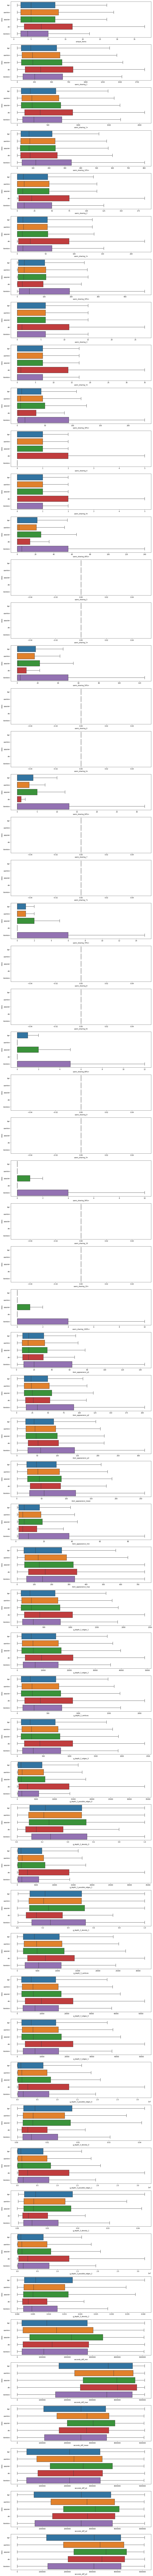

In [13]:
cols = data.drop(['user_id', 'class'], axis=1).columns.values[:60]
plt.rcParams['figure.figsize'] = [16, 5*len(cols)]
_, axes = plt.subplots(len(cols), 1)
for ax, col in zip(axes, cols):
    sns.boxplot(x=data[col], y=data['class'], ax=ax, showfliers=False)

In [ ]:
cols = data.drop(['user_id', 'class'], axis=1).columns.values[60:]
plt.rcParams['figure.figsize'] = [16, 5*len(cols)]
_, axes = plt.subplots(len(cols), 1)
for ax, col in zip(axes, cols):
    sns.boxplot(x=data[col], y=data['class'], ax=ax, showfliers=False)